# Using Distribution plot in MNIST

Here, we will use the MNIST dataset to train a simple Convolutional Neural Network (CNN) model. We will use the Distribution plot to visualize the training loss of the model.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

Model was taken from the PyTorch example: [github](https://github.com/pytorch/examples/tree/main/mnist)

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

#### Data Logger

A data logger is initialized for the path `mnist` and the data is cleared in case there are previous records.

In [3]:
import inspectus.data_logger

step = 0
tracker = inspectus.data_logger.DataLogger('mnist')
tracker.clear()

HTML(value='<pre  style="overflow-x: scroll;">Using /Users/lakshithnishshanke/Developer/labml/inspectus/notebo…

#### Training

At each training step, we find individual losses for every sample in the batch. This is done by setting the `reduction` parameter to `none` in the loss function. The loss is then saved to the data logger.

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    global step
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if loss.item() < 2.0:
            with torch.no_grad():
                tracker.save('train_loss', F.nll_loss(output, target, reduction='none'), step)
                step += 1

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))

In [5]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [6]:
torch.manual_seed(1)

device = torch.device("mps")

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1, shuffle=False)

model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.05)

In [7]:
for epoch in range(2):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.306055
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.580686
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.305781
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.380577
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.290491
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.355984
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.276714
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.191841
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.193744
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.196256

Test set: Average loss: 0.1206, Accuracy: 9623/10000 (96%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.193493
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.098507
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.246629
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.085876
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.124158
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.101729
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.425741
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.193585
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.102505
T

In [8]:
torch.save(model.state_dict(), "mnist_cnn.pt")

Here logged data are visualized using the Distribution plot. We also include the mean series in the plot and render the distribution with 5 bands

In [9]:
tl = tracker.read('train_loss')
inspectus.distribution({'train_loss': tl}, include_mean=True, levels=5)

alt.VConcatChart(...)

The distribution is visualized using five bands, where the central band represents the median (50th percentile). The other bands correspond to specific percentiles: 0, 6.68, 15.87, 30.85, 50.00, 69.15, 84.13, 93.32, and 100.00.

From the plot, we observe that the median loss is relatively low, below 0.1. However, there are also significantly higher values like 9, which are outliers. These outliers increase the mean loss due to their larger magnitude of contribution, even though they represent a small portion of the data.

Typically, we plot the mean loss at each training step. By setting `include_mean=True` in our function, we also render the mean loss on the plot. Upon close inspection, we notice that the mean is higher than the median, aligning with the third band. This difference is due to the influence of outliers.

In conclusion, the model's performance is actually better than what the mean loss indicates, excluding the outliers. To improve the model, we should investigate these outlier samples to determine if there are any issues with the data.


# Obtaining high loss samples

To obtain the samples with the highest loss, we first load the model and the test dataset. We then calculate the loss for each sample in the dataset and select the top 10 samples with the highest loss. Finally, we visualize these samples to understand why the model failed to predict them correctly.

In [10]:
model = Net().to(device)
model.load_state_dict(torch.load("mnist_cnn.pt"))
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [11]:
from torchvision import datasets

torch.manual_seed(1)

device = torch.device("mps")

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset = datasets.MNIST('../data', download=True, train=False,
                          transform=transform)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=False)

In [12]:
data, target = next(iter(train_loader))
data = data.to(device)
target = target.to(device)

output = model(data.to(device))
loss = F.nll_loss(output, target.to(device), reduction='none')

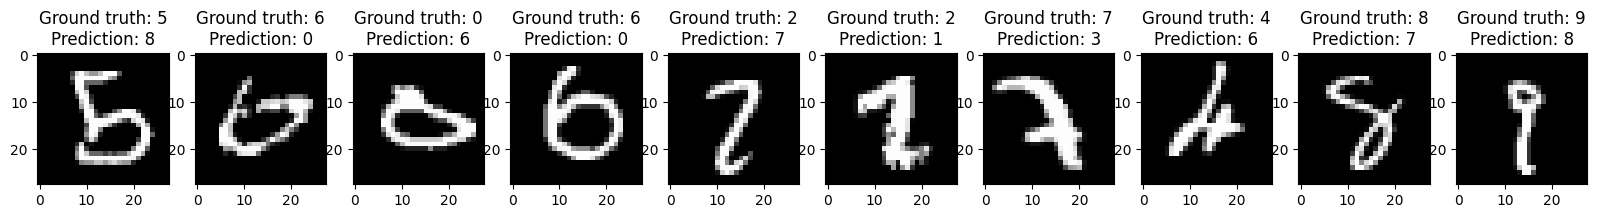

In [13]:
import matplotlib.pyplot as plt

top_losses = torch.topk(loss, 10)
fig, ax = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    ax[i].imshow(data[top_losses.indices[i]].cpu().numpy().reshape(28, 28), cmap='gray')
    ax[i].set_title(f"Ground truth: {target[top_losses.indices[i]].item()}\nPrediction: {output[top_losses.indices[i]].argmax().item()}")